# WAMECU Milestone 5 – End-to-End Pipeline

This notebook assembles the complete WAMECU cycle:

1. Instantiate a digital twin bias using inverse-mass weights.
2. Simulate drifting $\beta_t$ and stream synthetic draws.
3. Apply anomaly diagnostics (chi-square, entropy, correlations).
4. Adaptively estimate the latent bias coefficients.


In [1]:
import sys, pathlib
CURRENT_DIR = pathlib.Path().resolve()
for candidate in [CURRENT_DIR, *CURRENT_DIR.parents[:3]]:
    src_path = candidate / 'src'
    if src_path.exists():
        sys.path.append(str(src_path))
        break


## Imports and parameters

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from wamecu import run_wamecu_cycle

plt.style.use('seaborn-v0_8-whitegrid')
np.random.seed(321)


In [3]:
N_OUTCOMES = 6
N_STEPS = 400
WINDOW_SIZE = 50
SMOOTHING = 0.06
DRIFT_SCALE = 0.05

results = run_wamecu_cycle(
    n_outcomes=N_OUTCOMES,
    n_steps=N_STEPS,
    drift='sinusoidal',
    smoothing=SMOOTHING,
    window_size=WINDOW_SIZE,
    drift_scale=DRIFT_SCALE,
    seed=99,
)


## Digital twin configuration

In [4]:
baseline_summary = pd.DataFrame(
    {
        'Outcome': [f'Outcome {i}' for i in range(N_OUTCOMES)],
        'Weight': results['weights'],
        'Baseline probability': results['baseline_probabilities'],
        'Baseline $\beta$': results['baseline_beta'],
    }
)

baseline_summary


,Outcome,Weight,Baseline probability,Baseline $eta$
0,Outcome 0,1.0,0.204390,0.226340
1,Outcome 1,1.3,0.157223,-0.056662
2,Outcome 2,1.4,0.145993,-0.124043
3,Outcome 3,1.5,0.136260,-0.182440
4,Outcome 4,1.2,0.170325,0.021950
5,Outcome 5,1.1,0.185809,0.114855


## Probability drift over time

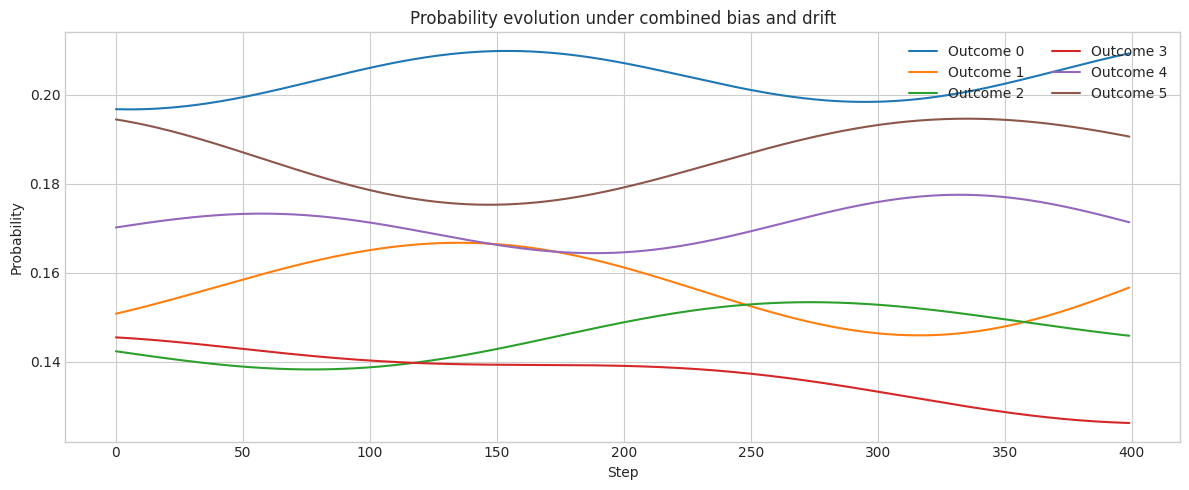

In [5]:
probabilities = results['probabilities']
fig, ax = plt.subplots(figsize=(12, 5))
for column in probabilities.columns[1:]:
    ax.plot(probabilities['step'], probabilities[column], label=column)
ax.set_title('Probability evolution under combined bias and drift')
ax.set_xlabel('Step')
ax.set_ylabel('Probability')
ax.legend(loc='upper right', ncol=2)
plt.tight_layout()
plt.show()


## Adaptive estimator vs. ground truth

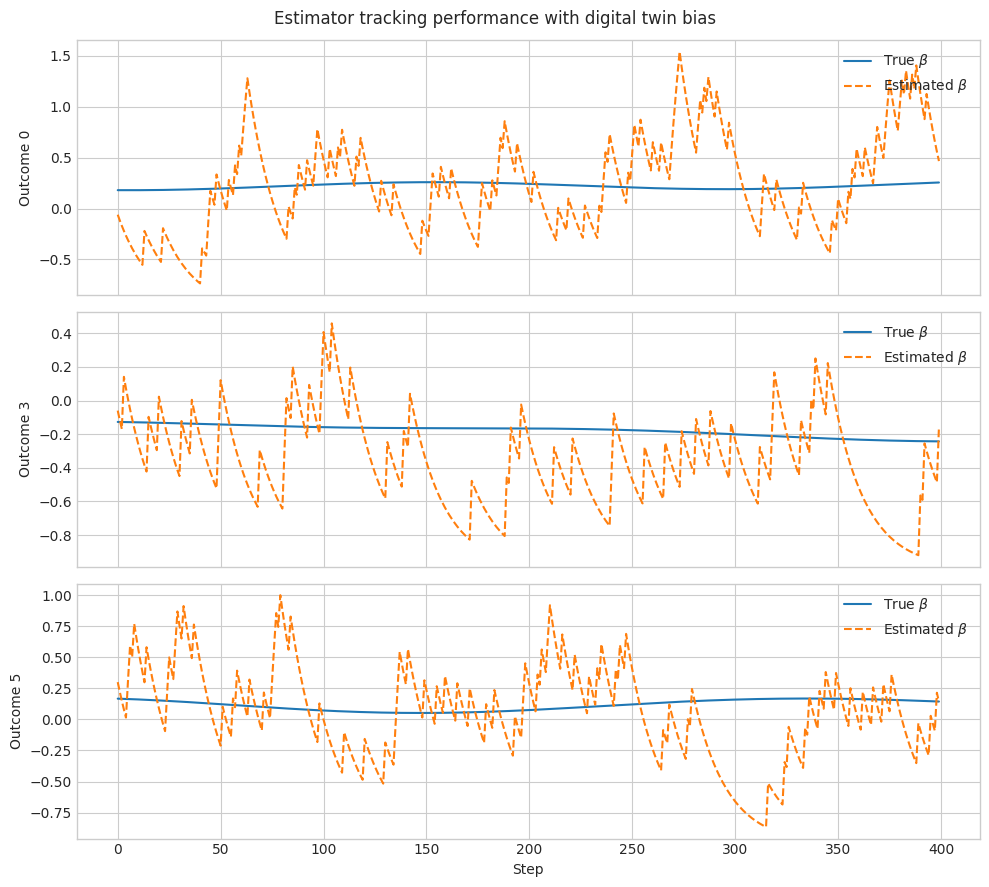

In [6]:
beta_true = pd.DataFrame(results['beta_series'], columns=[f'Outcome {i}' for i in range(N_OUTCOMES)])
beta_true.insert(0, 'step', np.arange(N_STEPS))

beta_est = pd.DataFrame(results['estimated_beta'], columns=[f'Outcome {i}' for i in range(N_OUTCOMES)])
beta_est.insert(0, 'step', np.arange(N_STEPS))

OUTCOMES_TO_PLOT = [0, 3, 5]
fig, axes = plt.subplots(len(OUTCOMES_TO_PLOT), 1, figsize=(10, 9), sharex=True)
for ax, idx in zip(axes, OUTCOMES_TO_PLOT):
    ax.plot(beta_true['step'], beta_true[f'Outcome {idx}'], label=r'True $\beta$')
    ax.plot(beta_est['step'], beta_est[f'Outcome {idx}'], label=r'Estimated $\beta$', linestyle='--')
    ax.set_ylabel(f'Outcome {idx}')
    ax.legend(loc='upper right')
axes[-1].set_xlabel('Step')
fig.suptitle('Estimator tracking performance with digital twin bias')
plt.tight_layout()
plt.show()


## Rolling anomaly diagnostics

<>:3: SyntaxWarning: invalid escape sequence '\c'
<>:4: SyntaxWarning: invalid escape sequence '\c'
<>:3: SyntaxWarning: invalid escape sequence '\c'
<>:4: SyntaxWarning: invalid escape sequence '\c'
/tmp/ipykernel_7019/1779506514.py:3: SyntaxWarning: invalid escape sequence '\c'
  axes[0].plot(anomalies['step'], anomalies['chi2_stat'], label='$\chi^2$ statistic', color='#d62728')
/tmp/ipykernel_7019/1779506514.py:4: SyntaxWarning: invalid escape sequence '\c'
  axes[0].set_ylabel('$\chi^2$')


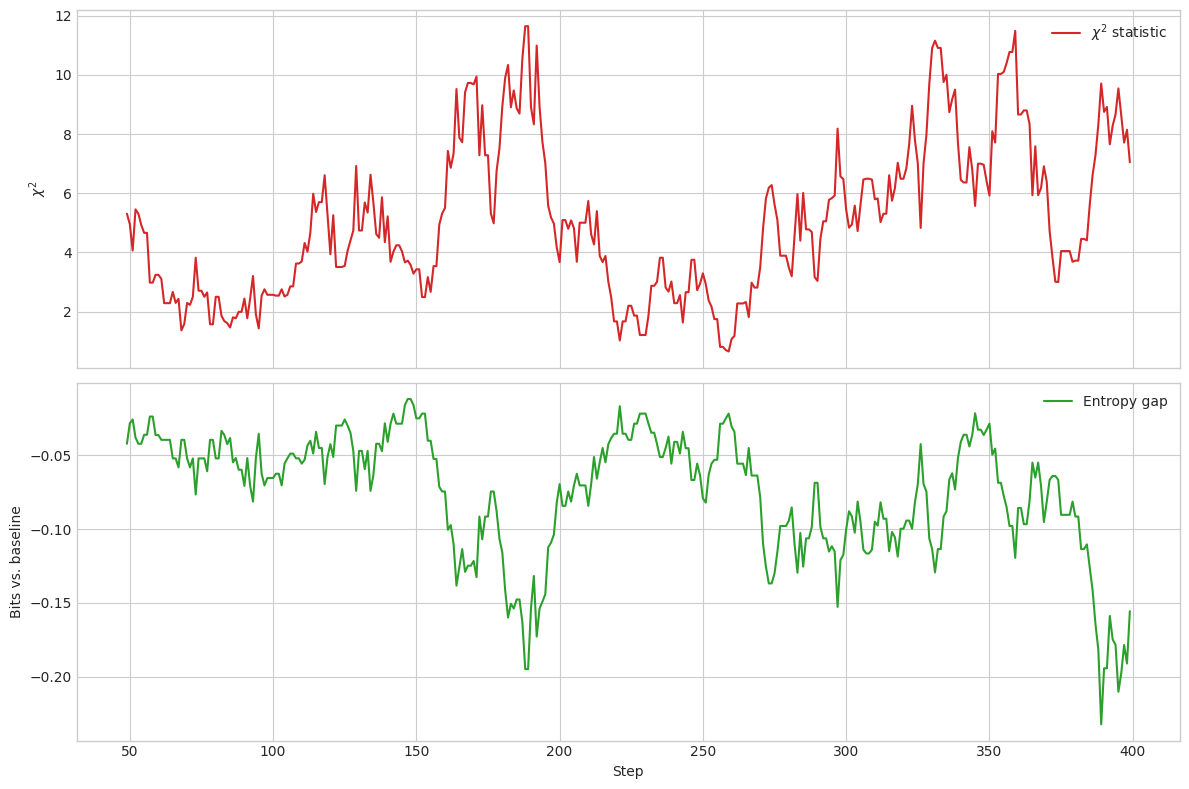

In [7]:
anomalies = results['anomalies']
fig, axes = plt.subplots(2, 1, figsize=(12, 8), sharex=True)
axes[0].plot(anomalies['step'], anomalies['chi2_stat'], label='$\chi^2$ statistic', color='#d62728')
axes[0].set_ylabel('$\chi^2$')
axes[0].legend(loc='upper right')

axes[1].plot(anomalies['step'], anomalies['entropy_gap'], label='Entropy gap', color='#2ca02c')
axes[1].set_xlabel('Step')
axes[1].set_ylabel('Bits vs. baseline')
axes[1].legend(loc='upper right')
plt.tight_layout()
plt.show()


## Outcome correlation check

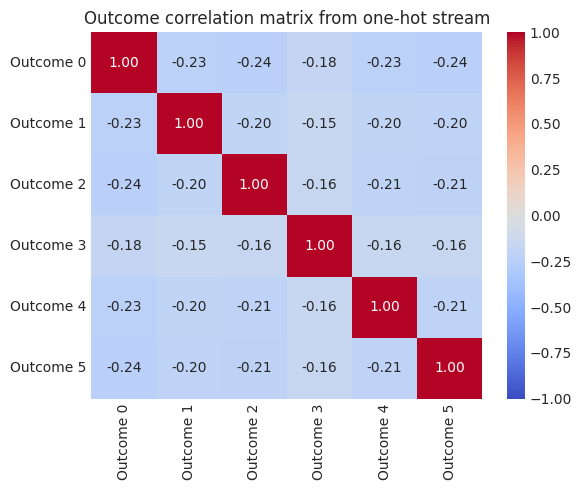

In [8]:
corr_matrix = pd.DataFrame(
    results['correlations'],
    columns=[f'Outcome {i}' for i in range(N_OUTCOMES)],
    index=[f'Outcome {i}' for i in range(N_OUTCOMES)],
)

plt.figure(figsize=(6, 5))
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Outcome correlation matrix from one-hot stream')
plt.tight_layout()
plt.show()


## Single-call runner for the WAMECU cycle

In [9]:
def run_full_cycle(**kwargs):
    """Execute the WAMECU pipeline with custom overrides."""
    defaults = dict(
        n_outcomes=6,
        n_steps=400,
        drift='sinusoidal',
        smoothing=0.06,
        window_size=50,
        drift_scale=0.05,
        seed=99,
    )
    defaults.update(kwargs)
    return run_wamecu_cycle(**defaults)

_ = run_full_cycle()
print('Cycle executed successfully.')


Cycle executed successfully.


The diagnostic suite highlights when the simulated system drifts away from its baseline, while the adaptive estimator keeps pace with the evolving $\beta$ landscape. This closes the loop for Milestone 5.